# Cucbic stiffness nonlinear SDOF PINN

## Problem overview

The example problem we solve here is the SDOF cubic oscillator:
$$
m \ddot{x} + cx + kx + k_3x^3 = 0~, \qquad \ddot{x} + \tilde{c}\dot{x} + \tilde{k}x + \tilde{k}_3x^3 = 0~, \qquad \tilde{\bullet}=\frac{\bullet}{m}
$$
with the initial conditions
$$
x(0) = 10\mathrm{mm}~~,~~\dot{x}(0) = 0~.
$$
Ground truth is simulated using M. Champneys' `mdof-toybox` package
<!-- This has the following exact solution:
$$
x(t) = x_0 \mathrm{cn}(\omega_{PCO}t,\sqrt{m_{PCO}})
$$
where $cn$ is the Jacobi elliptic function; $m_{PCO}$, elliptic parameter equals 0.5, and,
$$
\omega_{PCO} = \sqrt{\frac{k}{m}} x_0 = \bar{k}x_0
$$ -->

```python
pip install pytorch
pip install mdof-toybox
```

In [6]:
from sdof_pinn import bbnn, sdof_pinn, normalise, ParamClipper
from sdof_oscillators import cubic_duffing_sdof, add_noise

from math import pi

import toybox as tb

import numpy as np
import torch
import torch.nn as nn
device = torch.device("mps")

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate training data

> First, we generate some training data from a small part of the true analytical solution.

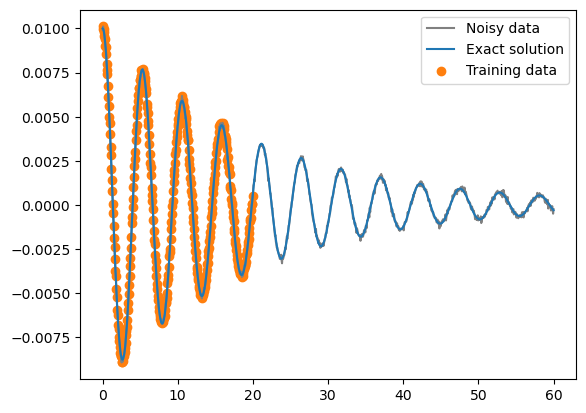

In [7]:
# get the analytical solution over the full domain

k_tild = np.sqrt(2.0)
m = 1.0
c_tild = 0.1
k3_tild = 4.0
nt = 1024
t = np.linspace(0,60,nt)

x0 = 0.01
v0 = 0

x = cubic_duffing_sdof(t, x0, v0, k_tild, c_tild, k3_tild)
x_noisy = add_noise(x, 0.01)
t = torch.tensor(t).view(-1,1).to(torch.float32)

# slice out a small number of points from the LHS of the domain
sub_ind = np.arange(0, int(nt/3), 1)
t_data = t[sub_ind]
x_data = x_noisy[sub_ind]

plt.figure()
plt.plot(t, x_noisy, color="gray", label="Noisy data")
plt.plot(t, x, label="Exact solution")
plt.scatter(t_data, x_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

Normalise

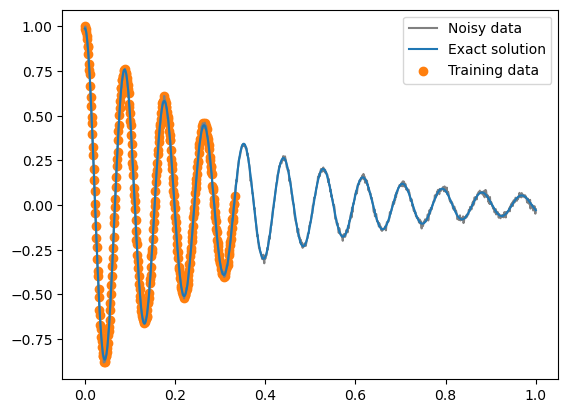

In [8]:
t_hat, alpha_t = normalise(t, "range")
x_hat, alpha_x = normalise(x_noisy, "range")
x_hat_gt = x/alpha_x
t_data = t_hat[sub_ind]
x_data = x_hat[sub_ind]
alphas = {
    "t" : alpha_t,
    "x" : alpha_x
}

plt.figure()
plt.plot(t_hat, x_hat, color="gray", label="Noisy data")
plt.plot(t_hat, x_hat_gt, label="Exact solution")
plt.scatter(t_data, x_data, color="tab:orange", label="Training data")
plt.legend()

## 'Black-box' network

$$
\textrm{argmin}\mathcal{L}(t;\mathbf{\theta}) := \langle \hat{x}^* - \mathcal{N}_x \rangle
$$

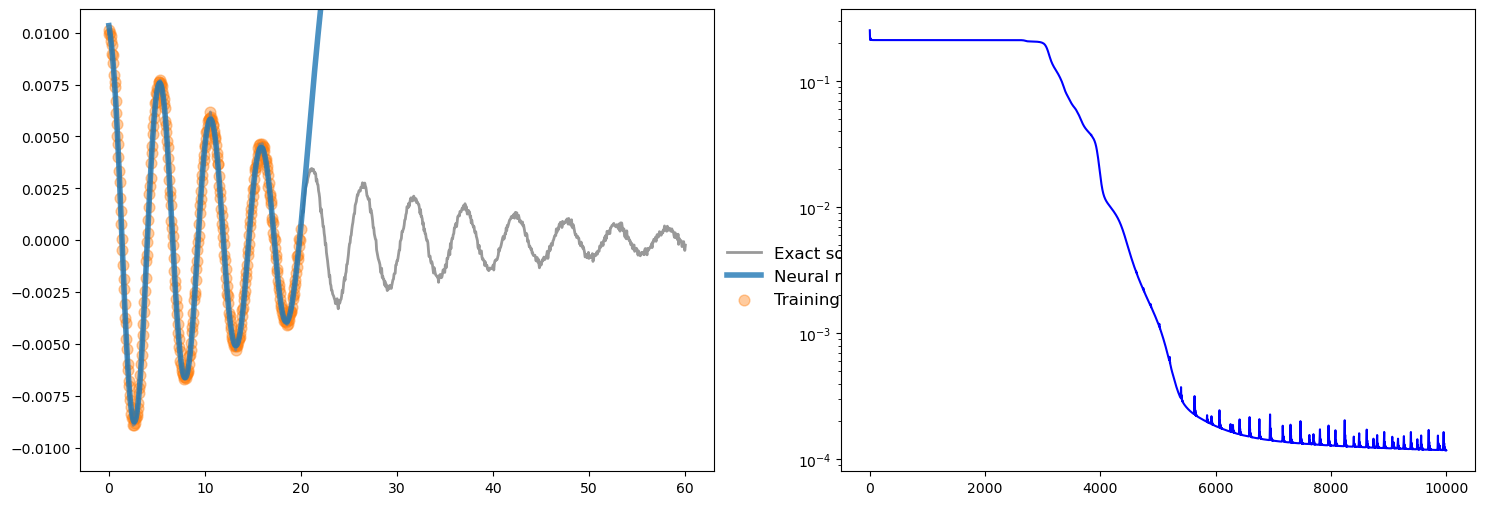

In [9]:
def plot_result(ax, t_hat, x_hat, t_data, x_data, xpred, alphas):
    ax.cla()
    ax.plot(t_hat*alphas["t"], x_hat*alphas["x"], color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    ax.plot(t_hat*alphas["t"], xpred*alphas["x"], color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    ax.scatter(t_data*alphas["t"], x_data*alphas["x"], s=60, color="tab:orange", alpha=0.4, label='Training data')
    l = ax.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    xL = torch.amax(t_hat)*alphas["t"]
    yL = torch.amax(torch.abs(x_hat))*alphas["x"]
    ax.set_xlim(-0.05*xL, 1.05*xL)
    ax.set_ylim(-1.1*yL, 1.1*yL)

def plot_loss_hist(ax,loss_hist):
    ax.cla()
    n_epoch = len(loss_hist)
    ax.plot(np.arange(1,n_epoch+1),loss_hist,'b')
    ax.set_yscale('log')
    
# train standard neural network to fit training data
torch.manual_seed(123)
bb_model = bbnn(1,1,32,2)
optimizer = torch.optim.Adam(bb_model.parameters(),lr=1e-3)
files = []
loss_hist = []
fig, axs = plt.subplots(1,2,figsize=(18,6),facecolor='w')
for i in range(10000):
    optimizer.zero_grad()
    loss = bb_model.loss_func(t_data, x_data)
    loss_hist.append(loss.item())
    loss.backward()
    optimizer.step()
     
    # plot the result as training progresses
    if (i+1) % 500 == 0: 
        
        xpred = bb_model(t_hat).detach()
        
        plot_result(axs[0], t_hat, x_hat, t_data, x_data, xpred, alphas)
    
        plot_loss_hist(axs[1],loss_hist)
        display.clear_output(wait=True)
        display.display(plt.gcf())

display.clear_output()

## PINN

$$
\textrm{argmin}\mathcal{L}(t;\mathbf{\theta}) = \mathcal{L}_a + \lambda\mathcal{L}_{ode}
$$

$$
\mathcal{L}_a = \langle \hat{x}^* - \mathcal{N}_{\hat{x}} \rangle _{\Omega_a}, \qquad
\mathcal{L}_{ode} = \langle \hat{m} \partial^2_{\hat{t}}\mathcal{N}_{\hat{x}} + \hat{c} \partial_{\hat{t}}\mathcal{N}_{\hat{x}} + \hat{k}\mathcal{N}_{\hat{x}} \rangle _{\Omega_d}
$$
where,
$$ \mathcal{N}_{\bullet} = \mathcal{N}_{\bullet}(\mathbf{x};\mathbf{\theta}), \qquad 
\partial_{*}\bullet = \frac{\partial\bullet}{\partial *}, \qquad 
\partial^2_{*}\bullet = \frac{\partial^2\bullet}{\partial *^2}, \qquad
\langle\bullet\rangle _{\Omega_{\kappa}} = \frac{1}{N_{\kappa}}\sum_{x\in\Omega_{\kappa}}\left|\left|\bullet\right|\right|^2 $$

ODE loss function comes from including the normalisation of the parameters, then choosing the suitable range to aid optimisation.

$$
\frac{\alpha_x}{\alpha_t^2} \partial^2_{\hat{t}}\hat{x} + \tilde{c}\frac{\alpha_x}{\alpha_t}\partial_{\hat{t}}\hat{x} + \tilde{k} \alpha_x \hat{x} + \tilde{k}_3 \alpha_x^3 \hat{x}^3 = 0 
\quad \rightarrow \quad 
\hat{m} \partial^2_{\hat{t}}\hat{x} + \hat{c} \partial_{\hat{t}}\hat{x} + \hat{k}\hat{x} + \hat{k}_3\hat{x}^3 = 0
$$
> trad(itional)
$$
\hat{m} = \frac{1}{\alpha_t^2}, \quad \hat{c} = \tilde{c}\frac{1}{\alpha_t}, \quad \hat{k} = \tilde{k}, \quad \hat{k}_3 = \tilde{k}\alpha_x^2
$$
> up_time
$$
\hat{m} = \frac{1}{\alpha_t}, \quad \hat{c} = \tilde{c}, \quad \hat{k} = \tilde{k}\alpha_t, \quad \hat{k}_3 = \tilde{k}\alpha_x^2\alpha_t
$$
> up_time2
$$
\hat{m} = 1, \quad \hat{c} = \tilde{c}\alpha_t, \quad \hat{k} = \tilde{k}\alpha_t^2, \quad \hat{k}_3 = \tilde{k}\alpha_x^2\alpha_t^2
$$

Epochs : 500000 ---- Loss: 2.49e-04 
c_tild: 0.1034 ---- k_tild: 1.4173 ---- k3_tild: 0.0000


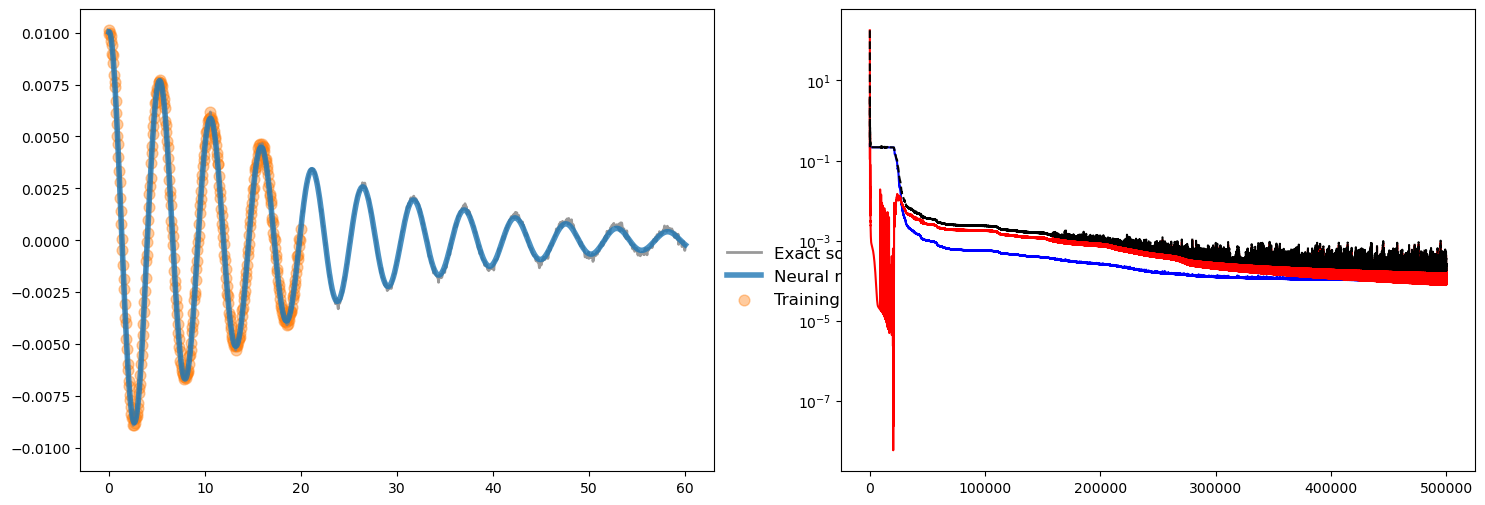

In [11]:
alpha_c = c_tild*10
alpha_k = k_tild*10
alpha_k3 = k3_tild*10
alphas = {
    "c" : alpha_c,
    "k" : alpha_k,
    "k3" : alpha_k3,
    "t" : alpha_t,
    "x" : alpha_x,
}

def plot_joint_loss_hist(ax,loss_hist):
    n_epoch = len(loss_hist)
    ax.cla()
    ax.plot(np.arange(1,n_epoch+1),loss_hist[:,0],'b',label="Observation loss")
    ax.plot(np.arange(1,n_epoch+1),loss_hist[:,1],'r',label="Physics loss")
    ax.plot(np.arange(1,n_epoch+1),loss_hist[:,2],'k--',label="Total loss")
    ax.set_yscale('log')

torch.manual_seed(123)
pi_model = sdof_pinn(
    N_INPUT = 1,
    N_OUTPUT = 1,
    N_HIDDEN = 32,
    N_LAYERS = 2
    )

# set nonlinearities
pi_model.nonlinearity("cubic_stiffness")

# set physical parameters as either constant or variable to be optimised over
# pi_model.set_phys_params(params={"k":k_tild,"c":c_tild,"k3":k3_tild}, par_type = "constant")
pi_model.set_phys_params(params={"k":1.0, "c":1.0, "k3":1.0}, par_type = "variable")

# set variable normalisation parameters and objective funcrtion style
pi_model.set_norm_params(alphas, "up_time")

t_physics = t_hat[::10].requires_grad_()

betas = (0.98,0.999)
epochs = int(500e3)

optimizer = torch.optim.Adam(pi_model.parameters(),lr=2e-3,betas=betas)

clipper = ParamClipper()

files = []
fig, axs = plt.subplots(1,2,figsize=(18,6),facecolor='w')
loss_hist=[]
lambds = [1, 1e-2]
for i in tqdm(range(epochs)):
    optimizer.zero_grad()

    loss, losses = pi_model.loss_func(t_physics, t_data, x_data, lambds)

    loss_hist.append([losses[0].item(), losses[1].item(), loss.item()])
    loss.backward()
    optimizer.step()

    pi_model.apply(clipper)
    
    # plot the result as training progresses
    if (i+1) % 500 == 0: 
        
        xpred = pi_model(t_hat).detach()
        
        plot_result(axs[0], t_hat, x_hat, t_data, x_data, xpred, alphas)

        plot_joint_loss_hist(axs[1],np.array(loss_hist))
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        match pi_model.param_type:
            case "constant":
                tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss))
            case "variable":
                tqdma.write("Epoch : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f ---- k3_tild: %.4f" % (i+1,loss,pi_model.phys_params[0]*alphas['c'],pi_model.phys_params[1]*alphas['k'],pi_model.phys_params[2]*alphas['k3']))

display.clear_output()
match pi_model.param_type:
            case "constant":
                tqdma.write("Epochs : %d ---- Loss: %.2e" % (i+1,loss))
            case "variable":
                tqdma.write("Epochs : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f ---- k3_tild: %.4f" % (i+1,loss,pi_model.phys_params[0]*alphas['c'],pi_model.phys_params[1]*alphas['k'],pi_model.phys_params[2]*alphas['k3']))